In [1]:
import os
import re
import numpy as np
import pandas as pd
import json

from matplotlib import pyplot as plt
from pprint import pprint

In [58]:
train_quac = pd.read_json("quac_train.squad.json")
train_quac = train_quac['data']

In [12]:
type(train_quac)

pandas.core.series.Series

In [13]:
train_quac

0        {'paragraphs': [{'context': 'According to the ...
1        {'paragraphs': [{'context': 'According to the ...
2        {'paragraphs': [{'context': 'According to the ...
3        {'paragraphs': [{'context': 'According to the ...
4        {'paragraphs': [{'context': 'According to the ...
                               ...                        
83563    {'paragraphs': [{'context': 'The band was foun...
83564    {'paragraphs': [{'context': 'The band was foun...
83565    {'paragraphs': [{'context': 'The band was foun...
83566    {'paragraphs': [{'context': 'The band was foun...
83567    {'paragraphs': [{'context': 'The band was foun...
Name: data, Length: 83568, dtype: object

In [63]:
pprint(train_quac[0])

{'paragraphs': [{'context': 'According to the Indian census of 2001, there '
                            'were 30,803,747 speakers of Malayalam in Kerala, '
                            'making up 93.2% of the total number of Malayalam '
                            'speakers in India, and 96.7% of the total '
                            'population of the state. There were a further '
                            '701,673 (2.1% of the total number) in Karnataka, '
                            '557,705 (1.7%) in Tamil Nadu and 406,358 (1.2%) '
                            'in Maharashtra. The number of Malayalam speakers '
                            'in Lakshadweep is 51,100, which is only 0.15% of '
                            'the total number, but is as much as about 84% of '
                            'the population of Lakshadweep. In all, Malayalis '
                            'made up 3.22% of the total Indian population in '
                            '2001. Of the total 33,066,

In [60]:
training_context = [sample['paragraphs'][0]['context'].rstrip(" CANNOTANSWER") for sample in train_quac]

(array([4.8086e+04, 2.9200e+04, 4.0830e+03, 3.8000e+01, 1.2800e+02,
        5.8200e+02, 5.6100e+02, 5.3800e+02, 3.2000e+02, 3.2000e+01]),
 array([ 250. ,  386.4,  522.8,  659.2,  795.6,  932. , 1068.4, 1204.8,
        1341.2, 1477.6, 1614. ]),
 <BarContainer object of 10 artists>)

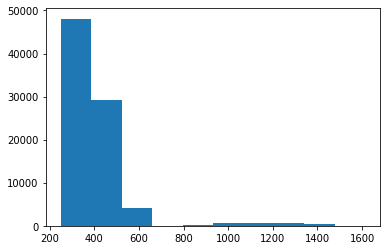

In [61]:
# Lets take a look at how many words are in our context paragraphs.
# It appears that the bulk of the context paragraphs are short enough.
# We won't eliminate the longer context items for now as the relevant text
# could be early in the context for those.

lengths = [len(context.split()) for context in training_context]
plt.hist(lengths)

In [128]:
training_context[0]

'According to the Indian census of 2001, there were 30,803,747 speakers of Malayalam in Kerala, making up 93.2% of the total number of Malayalam speakers in India, and 96.7% of the total population of the state. There were a further 701,673 (2.1% of the total number) in Karnataka, 557,705 (1.7%) in Tamil Nadu and 406,358 (1.2%) in Maharashtra. The number of Malayalam speakers in Lakshadweep is 51,100, which is only 0.15% of the total number, but is as much as about 84% of the population of Lakshadweep. In all, Malayalis made up 3.22% of the total Indian population in 2001. Of the total 33,066,392 Malayalam speakers in India in 2001, 33,015,420 spoke the standard dialects, 19,643 spoke the Yerava dialect and 31,329 spoke non-standard regional variations like Eranadan. As per the 1991 census data, 28.85% of all Malayalam speakers in India spoke a second language and 19.64% of the total knew three or more languages.  Large numbers of Malayalis have settled in Bangalore, Mangalore, Delhi, 

In [76]:
train_quac[0]['paragraphs'][0]['qas'][0]['answers'][0]['text']

'30,803,747 speakers of Malayalam in Kerala, making up 93.2% of the total number of Malayalam speakers in India,'

In [123]:
# For some reason I can't get this to work as single list comprehension.
# Note the special handling where there is no answer, we will remove those rows later

training_answers = [sample['paragraphs'][0]['qas'][0]['answers'] if sample else sample for sample in train_quac]
training_answers = [sample[0]['text'] if sample else sample for sample in training_answers]

In [124]:
training_answers[:10]

['30,803,747 speakers of Malayalam in Kerala, making up 93.2% of the total number of Malayalam speakers in India,',
 '33,015,420 spoke the standard dialects, 19,643 spoke the Yerava dialect and 31,329 spoke non-standard regional variations like Eranadan.',
 'World Malayalee Council, the organisation working with the Malayali diaspora across the Globe has embarked upon a project for making a data bank of the diaspora.',
 [],
 [],
 'In 2010, the Census of Population of Singapore reported that there were 26,348 Malayalees in Singapore.',
 [],
 'Malayalam is the language spoken by the Malayalis.',
 'Malayalam is derived from old Tamil and Sanskrit in the 6th century.',
 'Malayalam literature is ancient in origin. The oldest literature works in Malayalam, distinct from the Tamil tradition,']

In [125]:
training_questions = [sample['paragraphs'][0]['qas'][0]['question'] for sample in train_quac]

In [126]:
training_questions[:10]

['Where is Malayali located?',
 'What other languages are spoken there?',
 'What else is this place known for?',
 'Were they ever successful in doing this?',
 'Do they produce anything from here?',
 'Is this population still growing?',
 'Is the country thriving?',
 'what language do they speak?',
 'Do they speak any other languages?',
 'any literary items of interest?']

In [38]:
pprint (train_quac[18])

{'paragraphs': [{'context': 'After the audition process and several guest '
                            'vocalists on demos, the then 19-year-old Cove '
                            'Reber was announced as their new permanent lead '
                            'singer. Reber had sent in his demo tape, which '
                            'was an acoustic demo with "Mookie\'s Last '
                            'Christmas". The demo has since leaked onto the '
                            'internet. It is widely speculated to have '
                            'included a few songs from Translating the Name. '
                            'When Beau Burchell first heard the demo, he '
                            'thought it was Anthony playing a trick on them, '
                            "as Reber's vocal stylings were very similar to "
                            "those of Green's when the demo was originally "
                            'recorded.  In an interview with PlayPro.com, '
  

In [130]:
# Create our validation version....
validation_quac = pd.read_json("quac_val.squad.json")
validation_quac = validation_quac['data']
validation_context = [sample['paragraphs'][0]['context'].rstrip(" CANNOTANSWER") for sample in validation_quac]
validation_answers = [sample['paragraphs'][0]['qas'][0]['answers'] if sample else sample for sample in validation_quac]
validation_answers = [sample[0]['text'] if sample else sample for sample in validation_answers]
validation_questions = [sample['paragraphs'][0]['qas'][0]['question'] for sample in validation_quac]

In [131]:
validation_context[0]

'In May 1983, she married Nikos Karvelas, a composer, with whom she collaborated in 1975 and in November she gave birth to her daughter Sofia. After their marriage, she started a close collaboration with Karvelas. Since 1975, all her releases have become gold or platinum and have included songs by Karvelas. In 1986, she participated at the Cypriot National Final for Eurovision Song Contest with the song Thelo Na Gino Star ("I Want To Be A Star"), taking second place. This song is still unreleased up to date. In 1984, Vissi left her record company EMI Greece and signed with CBS Records Greece, which later became Sony Music Greece, a collaboration that lasted until 2013. In March 1984, she released Na \'Hes Kardia ("If You Had a Heart"). The album was certified gold. The following year her seventh album Kati Simveni ("Something Is Happening") was released which included one of her most famous songs, titled "Dodeka" ["Twelve (O\'Clock)"] and reached gold status selling 80.000 units. In 19

In [132]:
validation_answers[:10]

['In May 1983, she married Nikos Karvelas, a composer,',
 'in November she gave birth to her daughter Sofia.',
 [],
 'Since 1975, all her releases have become gold or platinum and have included songs by Karvelas.',
 [],
 'one of her most famous songs, titled "Dodeka" ["Twelve (O\'Clock)"]',
 'reached gold status selling 80.000 units.',
 'The album included the hit Pragmata ("Things") and went platinum,',
 'probably FSB) are known to have targeted the webmail account of the murdered Russian journalist Anna Politkovskaya.',
 'On 5 December 2005, RFIS initiated an attack against the account annapolitovskaya@US Provider1, by deploying malicious software']

In [133]:
validation_questions[:10]

['what happened in 1983?',
 'did they have any children?',
 'did she have any other children?',
 'what collaborations did she do with nikos?',
 'what influences does he have in her music?',
 'what were some of the songs?',
 'how famous was it?',
 'did she have any other famous songs?',
 'Did they have any clues?',
 'How did they target her email?']

In [159]:
# Create our training dataframe, we replace empty answers with NaN
# When we are done we eliminate rows without answers

training_df = pd.DataFrame()
training_df['context'] = training_context
training_df['answer'] = training_answers
training_df['answer'] = training_df['answer'].apply(lambda x: x if x else np.nan)
training_df['question'] = training_questions
training_df

,context,answer,question
0,"According to the Indian census of 2001, there ...","30,803,747 speakers of Malayalam in Kerala, ma...",Where is Malayali located?
1,"According to the Indian census of 2001, there ...","33,015,420 spoke the standard dialects, 19,643...",What other languages are spoken there?
2,"According to the Indian census of 2001, there ...","World Malayalee Council, the organisation work...",What else is this place known for?
3,"According to the Indian census of 2001, there ...",NaN,Were they ever successful in doing this?
4,"According to the Indian census of 2001, there ...",NaN,Do they produce anything from here?
...,...,...,...
83563,The band was founded by Marko Paasikoski (guit...,"Originally named Tricky Beans, they played har...",Did they know each other previously?
83564,The band was founded by Marko Paasikoski (guit...,because they thought they wouldn't be able to ...,Why did the change the name?
83565,The band was founded by Marko Paasikoski (guit...,"""Sonata Arctica"" was suggested by a friend of ...",How did they decide on Sonata Arctica for the ...
83566,The band was founded by Marko Paasikoski (guit...,"the band was going to play ""a mixture of Megad...",Did they have any influences?


In [160]:
training_df = training_df.dropna()
training_df

,context,answer,question
0,"According to the Indian census of 2001, there ...","30,803,747 speakers of Malayalam in Kerala, ma...",Where is Malayali located?
1,"According to the Indian census of 2001, there ...","33,015,420 spoke the standard dialects, 19,643...",What other languages are spoken there?
2,"According to the Indian census of 2001, there ...","World Malayalee Council, the organisation work...",What else is this place known for?
5,"According to the Indian census of 2001, there ...","In 2010, the Census of Population of Singapore...",Is this population still growing?
7,Malayalam is the language spoken by the Malaya...,Malayalam is the language spoken by the Malaya...,what language do they speak?
...,...,...,...
83563,The band was founded by Marko Paasikoski (guit...,"Originally named Tricky Beans, they played har...",Did they know each other previously?
83564,The band was founded by Marko Paasikoski (guit...,because they thought they wouldn't be able to ...,Why did the change the name?
83565,The band was founded by Marko Paasikoski (guit...,"""Sonata Arctica"" was suggested by a friend of ...",How did they decide on Sonata Arctica for the ...
83566,The band was founded by Marko Paasikoski (guit...,"the band was going to play ""a mixture of Megad...",Did they have any influences?


In [149]:
# Now create the validation dataframe

In [161]:
# Create our training dataframe, we replace empty answers with NaN
# When we are done we eliminate rows without answers

validation_df = pd.DataFrame()
validation_df['context'] = validation_context
validation_df['answer'] = validation_answers
validation_df['answer'] = validation_df['answer'].apply(lambda x: x if x else np.nan)
validation_df['question'] = validation_questions
validation_df

,context,answer,question
0,"In May 1983, she married Nikos Karvelas, a com...","In May 1983, she married Nikos Karvelas, a com...",what happened in 1983?
1,"In May 1983, she married Nikos Karvelas, a com...",in November she gave birth to her daughter Sofia.,did they have any children?
2,"In May 1983, she married Nikos Karvelas, a com...",NaN,did she have any other children?
3,"In May 1983, she married Nikos Karvelas, a com...","Since 1975, all her releases have become gold ...",what collaborations did she do with nikos?
4,"In May 1983, she married Nikos Karvelas, a com...",NaN,what influences does he have in her music?
...,...,...,...
7349,"In 1963, Major League Baseball expanded the st...","Facing the Yankees in the 1963 World Series, K...",How did Koufax perform in the post-season?
7350,"In 1963, Major League Baseball expanded the st...","The top pitchers of the era - Don Drysdale, Ju...",Are there any other interesting aspects about ...
7351,"In 1963, Major League Baseball expanded the st...",NaN,How did this change in walks affect the game o...
7352,"In 1963, Major League Baseball expanded the st...",NaN,How did the league respond to this change?


In [163]:
validation_df = validation_df.dropna()
validation_df

,context,answer,question
0,"In May 1983, she married Nikos Karvelas, a com...","In May 1983, she married Nikos Karvelas, a com...",what happened in 1983?
1,"In May 1983, she married Nikos Karvelas, a com...",in November she gave birth to her daughter Sofia.,did they have any children?
3,"In May 1983, she married Nikos Karvelas, a com...","Since 1975, all her releases have become gold ...",what collaborations did she do with nikos?
5,"In May 1983, she married Nikos Karvelas, a com...","one of her most famous songs, titled ""Dodeka"" ...",what were some of the songs?
6,"In May 1983, she married Nikos Karvelas, a com...",reached gold status selling 80.000 units.,how famous was it?
...,...,...,...
7346,"In 1963, Major League Baseball expanded the st...","Koufax threw 11 shutouts, setting a new post-1...",What records did Koufax set in 1963?
7347,"In 1963, Major League Baseball expanded the st...","On May 11, Koufax no-hit the San Francisco Gia...",How did the team do in 1963?
7348,"In 1963, Major League Baseball expanded the st...",Koufax carried a perfect game into the eighth ...,In what other games did Koufax perform well?
7349,"In 1963, Major League Baseball expanded the st...","Facing the Yankees in the 1963 World Series, K...",How did Koufax perform in the post-season?
